In [1]:
# Copyright (c) TorchGeo Contributors. All rights reserved.
# Licensed under the MIT License.

# Pretrained Weights

_Written by: Caleb Robinson_

In this tutorial, we will demonstrate how to use pretrained models in TorchGeo to extract fixed-length embeddings from remote sensing imagery. This is useful for quickly exploring datasets, visualizing feature spaces, and establishing baseline performance without the need for extensive training.

Specifically, we will:

- Load the **EuroSAT** dataset using TorchGeo's Lightning `DataModule`.
- Load two pretrained encoders:
  1) **DOFA** (a ViT‑B/16–style encoder fine‑tuned for Earth observation) — outputs 768‑D features.
  2) **ResNet‑18** (using weights from SSL4EO) — outputs 512-D features.
- Extract fixed‑length embeddings for every image without labels (no gradient / just forward passes).
- Train a simple k‑Nearest Neighbors classifier on the embeddings to quantify linear separability.
- Visualize the feature space with a 2‑D PCA plot to see class separation.

## Setup

First, we install TorchGeo.

In [ ]:
# On Colab, this ensures the latest TorchGeo is available.

%pip install torchgeo

## Imports

Next, we import TorchGeo and any other libraries we need.

In [ ]:
import os
import tempfile

from tqdm import tqdm
import torch
import numpy as np
import kornia.augmentation as K
import matplotlib.pyplot as plt

from torchgeo.datamodules import EuroSAT100DataModule, EuroSATDataModule
from torchgeo.models import ResNet18_Weights, DOFABase16_Weights, get_model

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

The following variables can be used to control embedding.

In [2]:
batch_size = 64
num_workers = 8
fast_dev_run = False

## Datamodule

We will utilize TorchGeo's [Lightning](https://lightning.ai/docs/pytorch/stable/) datamodules to organize the dataloader setup.

In [ ]:
# Build EuroSAT DataModule (train/val loaders) using TorchGeo Lightning utilities.

root = os.path.join(tempfile.gettempdir(), 'eurosat')
datamodule = EuroSATDataModule(
    root=root, batch_size=batch_size, num_workers=num_workers, download=True, bands=('B02', 'B03', 'B04')
)
datamodule.setup("fit")
datamodule.setup("validate")
datamodule.setup("test")

train_dl = datamodule.train_dataloader()
val_dl = datamodule.val_dataloader()
test_dl = datamodule.test_dataloader()

## Embedding

We will embed the entirety of EuroSAT train and validation splits using a pretrained model by extracting features from the final layer before the classification head.

With the DOFA model this will give us 768-dimensional feature vectors from each image. We use these vectors with the labels to train and evaluate a simple k-nearest neighbors classifier.

In [4]:
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load the DOFA pretrained encoder (ViT‑style) and move it to device.

model = get_model("dofa_base_patch16_224", weights=DOFABase16_Weights.DOFA_MAE)
model = model.eval().to(accelerator)

resize = K.Resize((224, 224))  # DOFA model expects 224x224 inputs

In [ ]:
def embed_dofa(model, dataloader, accelerator, transforms=None):
    """Helper function to embed the samples from a dataloader using a DOFA model."""
    x_all = []
    y_all = []
    for batch in tqdm(dataloader):
        x = batch['image'].to(accelerator)
        y = batch['label']
        x = x.to(accelerator)
        if transforms is not None:
            x = transforms(x)

        with torch.inference_mode():
             # DOFA requires us to forward the central wavelengths of each bands
            embeddings = model.forward_features(x, wavelengths=[0.49, 0.56, 0.66])  # these are B02, B03, B04 wavelengths for Sentinel-2
        x_all.append(embeddings.cpu().numpy())
        y_all.append(y.numpy())
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return x_all, y_all

In [ ]:
x_train, y_train = embed_dofa(model, train_dl, accelerator, transforms=resize)
x_val, y_val = embed_dofa(model, val_dl, accelerator, transforms=resize)

100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


In [ ]:
# Fit a k‑NN classifier on DOFA train embeddings and evaluate on validation embeddings.
# This gives a quick, label‑efficient baseline without fine‑tuning.

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_val)

In [9]:
print(classification_report(y_val, y_pred, digits=2, zero_division=0))

              precision    recall  f1-score   support

           0       0.40      0.64      0.49       613
           1       0.76      0.86      0.81       605
           2       0.41      0.65      0.50       628
           3       0.29      0.15      0.20       499
           4       0.85      0.54      0.66       507
           5       0.59      0.70      0.64       409
           6       0.47      0.33      0.39       481
           7       0.54      0.27      0.36       583
           8       0.54      0.35      0.42       511
           9       0.69      0.87      0.77       564

    accuracy                           0.55      5400
   macro avg       0.56      0.54      0.52      5400
weighted avg       0.55      0.55      0.53      5400



Now let's do the same thing with a ResNet18 model pretrained on Sentinel-2 RGB imagery (from the SSL4EO paper).

We reuse the same dataloaders and evaluation code to isolate the effect of the encoder.

In [ ]:
# We can instantiate a ResNet18 model in a similar way to the DOFA model above.

model = get_model("resnet18", weights=ResNet18_Weights.SENTINEL2_RGB_MOCO)
model = model.eval().to(accelerator)

In [ ]:
def embed_standard(model, dataloader, accelerator, transforms=None):
    x_all = []
    y_all = []
    for batch in tqdm(dataloader):
        x = batch['image'].to(accelerator)
        y = batch['label']
        x = x.to(accelerator)
        if transforms is not None:
            x = transforms(x)

        with torch.inference_mode():
            embeddings = model.forward_features(x)
            embeddings = torch.mean(embeddings, dim=(-2, -1))  # global average pooling over the spatial dims
        x_all.append(embeddings.cpu().numpy())
        y_all.append(y.numpy())
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return x_all, y_all

In [ ]:
x_train, y_train = embed_standard(model, train_dl, accelerator, transforms=resize)
x_val, y_val = embed_standard(model, val_dl, accelerator, transforms=resize)

100%|██████████| 85/85 [00:04<00:00, 19.80it/s]


In [13]:
# Fit/evaluate k‑NN on ResNet‑18 embeddings for a side‑by‑side comparison.

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_val)

In [14]:
print(classification_report(y_val, y_pred, digits=2, zero_division=0))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       613
           1       0.86      0.93      0.90       605
           2       0.68      0.70      0.69       628
           3       0.42      0.33      0.37       499
           4       0.86      0.84      0.85       507
           5       0.65      0.76      0.70       409
           6       0.53      0.56      0.55       481
           7       0.75      0.84      0.79       583
           8       0.70      0.53      0.60       511
           9       0.91      0.90      0.91       564

    accuracy                           0.72      5400
   macro avg       0.71      0.71      0.71      5400
weighted avg       0.71      0.72      0.71      5400



In [ ]:
pca = PCA(n_components=2, whiten=True)
x_reduced = pca.fit_transform(x_train)
print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum()}')

Explained variance ratio: 0.8957633376121521


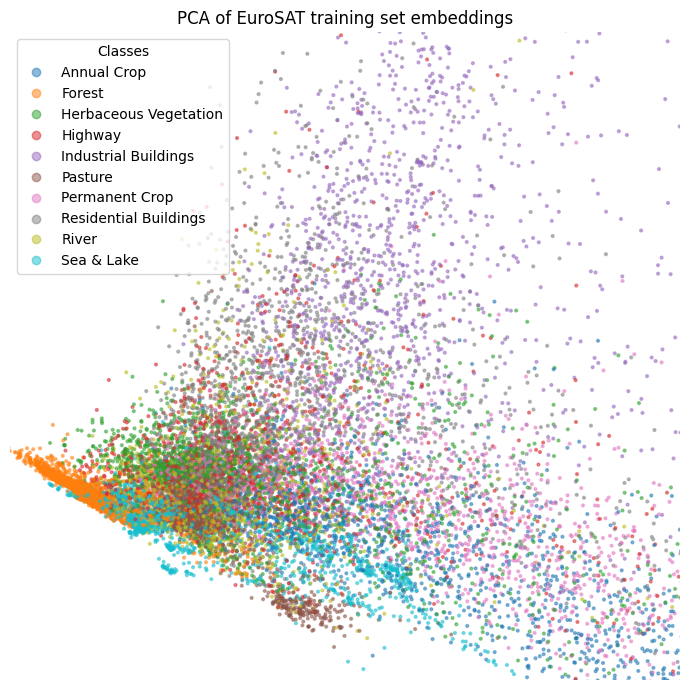

In [ ]:
class_names = [
    "Annual Crop",
    "Forest",
    "Herbaceous Vegetation",
    "Highway",
    "Industrial Buildings",
    "Pasture",
    "Permanent Crop",
    "Residential Buildings",
    "River",
    "Sea & Lake",
]

fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
scatter = plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_train, cmap='tab10', s=4, alpha=0.5)
handles, _ = scatter.legend_elements()
labels = [class_names[i] for i in range(10)]
plt.legend(handles, labels, title="Classes", loc='best')
plt.title('PCA of EuroSAT training set embeddings')
plt.xlim([-1.5, 2])
plt.ylim([-1, 2])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()